# TensorBoard可视化应用示例

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

## 导入数据集

In [2]:
# 定义数据标准化变换
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 加载训练数据集
trainset = torchvision.datasets.FashionMNIST('./data', download = True, train =True, transform = transform) 
# 加载测试数据集
testset = torchvision.datasets.FashionMNIST('./data', download= True, train = False, transform=transform) 

#训练集形成一批一批的可迭代的数据对象
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 0)
#测试集形成一批一批的可迭代的数据对象
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = True, num_workers =0) 

#10个标签类
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

## 定义网络模型、损失函数、优化器

In [3]:
#定义一个神经网络类
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#实例化
net = Net()
#交叉信息熵，损失函数 
criterion = nn.CrossEntropyLoss()
#优化方式为梯度下降
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum= 0.9)

## TensorBoard初始化

把`TensorBoard`当成一个数据看板进行初始化，后面的绘图之类的工作都可以`add`到这个看板上面去，初始化后会在代码的同级文件夹创建一个`runs/fashion_mnist_experiment_1`文件夹用来存放可视化对象。

In [4]:
from torch.utils.tensorboard import SummaryWriter 

#tensorboard初始化
#创建一个runs/fashion_mnist_experiment_1文件夹
writer = SummaryWriter('runs/fashion_mnist_experiment_1') 

执行命令行`tensorboard --logdir=C:\\Users\\leo\\Desktop\\PyTorch程序设计-3.27`  

打开`http://localhost:6006/`

![jupyter](./image/TB_link.jpg)

![jupyter](./image/localhost.jpg)

## add image

有了`TensorBoard`数据看板，现在就可以往里面`add`数据图像磁贴，比如随机抽取4个训练样本组合网格拼图写入`TensorBoard`里面。

In [5]:
dataiter = iter(trainloader) #创建迭代器
images, labels = next(dataiter) #获取迭代器中的下一个值
img_grid = torchvision.utils.make_grid(images) #将若干幅图像拼成一幅图像
writer.add_image('four_fashion_mnist_images', img_grid) #images写入到TensorBoard

![jupyter](./image/add_image.png)

## add  graph

`TensorBoard`不单单可以将样本可视化，更重要的还可以监察模型，展示模型结构，可以点击节点的“+”号展开查看更详细的参数和结构。

In [6]:
writer.add_graph(net, images) #神经网络graph写入tensorboard
writer.close()

![jupyter](./image/add_graph.png)

## 定义函数用于模型判别的可视化

In [7]:
def matplotlib_imshow(img, one_channel = False): #样本数据可视化
    if one_channel:
        img = img.mean(dim =0)
    img = img /2 +0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap = 'Greys')
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))
        
def images_to_probs(net, images): #概率预测
    # 将一个batch的图片送至模型net，得到output.shape为torch.Size([4, 10])
    output = net(images)
    # 返回每一行中值最大的元素，且返回索引，得到preds_tensor.shape为torch.Size([4])
    _, preds_tensor = torch.max(output, 1) 
    preds = preds_tensor.numpy()
    # softmax多个输出值转换成多个概率值，其中el.shape为torch.Size([10])
    return preds, [F.softmax(el, dim = 0)[i].item() for i, el in zip(preds, output)] 

def plot_classes_preds(net, images, labels): #概率类别结果可视化
    preds, probs = images_to_probs(net, images) 
    fig = plt.figure(figsize = (12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks =[], yticks = [])
        matplotlib_imshow(images[idx], one_channel= True)
        ax.set_title("{0}, {1:.1}%\n(label: {2}".format(
            classes[preds[idx]],
            probs[idx]*100.0,
            classes[labels[idx]]),
            color = ("green" if preds[idx]==labels[idx].item() else "red")) #颜色标志
    return fig

torch.Size([4, 10])
torch.Size([4])
[4 7 4 4]
4 0.9806510806083679
7 0.9998102784156799
4 0.7097857594490051
4 0.9930176734924316


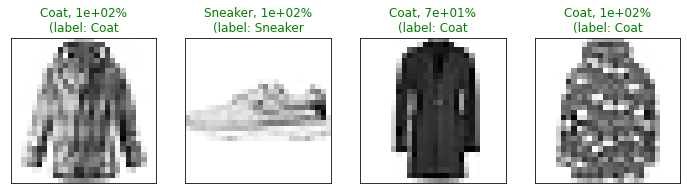

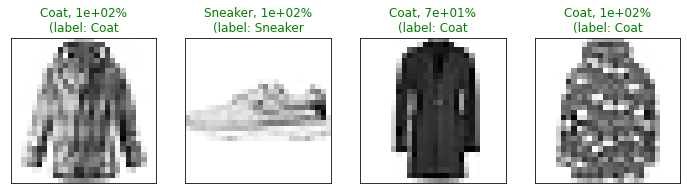

In [8]:
trained_net = torch.load('Tensorboard_model.pth')
images, labels = next(iter(trainloader))
output = trained_net(images)
print(output.shape)
_, preds_tensor = torch.max(output, 1) 
print(preds_tensor.shape)
preds = preds_tensor.numpy()
print(preds)
for i, el in zip(preds, output):
    print(i, F.softmax(el, dim = 0)[i].item())
plot_classes_preds(trained_net, images, labels)

## tracking model & add scalar

In [9]:
running_loss = 0.0
for epoch in range(10): 
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # 每隔1000次写入
        if i % 1000 == 999:   
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


In [10]:
torch.save(net,'Tensorboard_model.pth')

![jupyter](./image/add_result.png)

![jupyter](./image/add_scalar.png)

In [11]:
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0): #绘制precision-recall曲线
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]
    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

for i in range(len(classes)): #为每一类绘制precision-recall曲线
    add_pr_curve_tensorboard(i, test_probs, test_preds)

![jupyter](./image/add_PR.png)